In [1]:
! [ -e /content ] && pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.8/719.8 KB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.7/468.7 KB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 21.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 25.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 KB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 KB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 22.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 KB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 KB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 26.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 KB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 KB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
from fastbook import *

In [3]:
from fastai.vision.all import *
path = untar_data(URLs.IMAGENETTE)

In [4]:
dblock = DataBlock(blocks=(ImageBlock(), CategoryBlock()),
                   get_items=get_image_files,
                   get_y=parent_label,
                   item_tfms=Resize(460),
                   batch_tfms=aug_transforms(size=224, min_scale=0.75))
dls = dblock.dataloaders(path, bs=64)

In [5]:
model = xresnet50(n_out=dls.c)
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=accuracy)
learn.fit_one_cycle(2, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.505724,1.854731,0.401419,03:16
1,0.993631,0.846009,0.740478,03:09


#Normalization

In [6]:
x,y = dls.one_batch()
x.mean(dim=[0,2,3]),x.std(dim=[0,2,3])

(TensorImage([0.4374, 0.4296, 0.3928], device='cuda:0'),
 TensorImage([0.2807, 0.2766, 0.2917], device='cuda:0'))

In [7]:
def get_dls(bs, size):
    dblock = DataBlock(blocks=(ImageBlock, CategoryBlock),
                   get_items=get_image_files,
                   get_y=parent_label,
                   item_tfms=Resize(460),
                   batch_tfms=[*aug_transforms(size=size, min_scale=0.75),
                               Normalize.from_stats(*imagenet_stats)])
    return dblock.dataloaders(path, bs=bs)

In [8]:
dls = get_dls(64, 224)

In [9]:
x,y = dls.one_batch()
x.mean(dim=[0,2,3]),x.std(dim=[0,2,3])

(TensorImage([-0.0961,  0.0193,  0.1174], device='cuda:0'),
 TensorImage([1.2062, 1.2295, 1.3034], device='cuda:0'))

In [10]:
model = xresnet50(n_out=dls.c)
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=accuracy)
learn.fit_one_cycle(5, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.631077,3.462213,0.370052,03:08
1,1.239115,1.184803,0.638536,03:16
2,0.933507,1.085330,0.669903,03:10
3,0.751352,0.789884,0.741225,03:09
4,0.581502,0.586925,0.809933,03:10


# Progressive Resizing

In [11]:
dls = get_dls(128, 128)
learn = Learner(dls, xresnet50(n_out=dls.c), loss_func=CrossEntropyLossFlat(), 
                metrics=accuracy)
learn.fit_one_cycle(4, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.599347,2.426148,0.444361,02:46
1,1.263893,1.609975,0.533981,02:44
2,0.980690,0.828151,0.736744,02:45
3,0.769156,0.665321,0.796490,02:45


In [12]:
learn.dls = get_dls(64, 224)
learn.fine_tune(5, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.870017,1.936810,0.561240,03:13


epoch,train_loss,valid_loss,accuracy,time
0,0.640953,0.711885,0.773338,03:11
1,0.653436,0.603670,0.805078,03:10
2,0.585240,0.635574,0.807319,03:11
3,0.491012,0.512547,0.836445,03:10
4,0.427601,0.461362,0.853996,03:12


# Test Time Augmentation

In [13]:
preds,targs = learn.tta()
accuracy(preds, targs).item()

0.8581030368804932

# Mixup

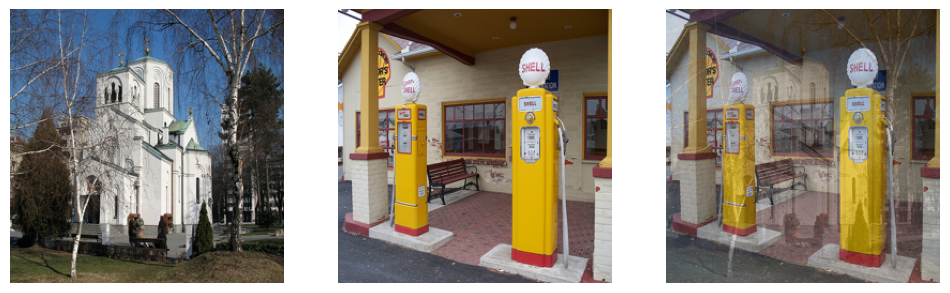

In [14]:
#hide_input
#id mixup_example
#caption Mixing a church and a gas station
#alt An image of a church, a gas station and the two mixed up.
church = PILImage.create(get_image_files_sorted(path/'train'/'n03028079')[0])
gas = PILImage.create(get_image_files_sorted(path/'train'/'n03425413')[0])
church = church.resize((256,256))
gas = gas.resize((256,256))
tchurch = tensor(church).float() / 255.
tgas = tensor(gas).float() / 255.

_,axs = plt.subplots(1, 3, figsize=(12,4))
show_image(tchurch, ax=axs[0]);
show_image(tgas, ax=axs[1]);
show_image((0.3*tchurch + 0.7*tgas), ax=axs[2]);


In [15]:
model = xresnet50(n_out=dls.c)
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), 
                metrics=accuracy, cbs=MixUp())
learn.fit_one_cycle(5, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.899573,3.171257,0.353622,02:44
1,1.674774,1.565195,0.539955,02:45
2,1.495374,1.424711,0.555265,02:43
3,1.328319,0.808638,0.754294,02:45
4,1.197097,0.698825,0.784541,02:43


# Label Smoothing

In [ ]:
model = xresnet50(n_out=dls.c)
learn = Learner(dls, model, loss_func=LabelSmoothingCrossEntropy(), 
                metrics=accuracy)
learn.fit_one_cycle(5, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.766840,3.330451,0.321509,02:44
